<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using device: cpu
Code parameters: N=128, K=64, Rate=0.500, RM order=3
Running SC decoder...
SNR=0.0 dB: BER=4.95e-01, BLER=1.00e+00
SNR=0.5 dB: BER=4.95e-01, BLER=1.00e+00
SNR=1.0 dB: BER=4.94e-01, BLER=1.00e+00
SNR=1.5 dB: BER=4.94e-01, BLER=1.00e+00
SNR=2.0 dB: BER=4.95e-01, BLER=1.00e+00
SNR=2.5 dB: BER=4.93e-01, BLER=1.00e+00
SNR=3.0 dB: BER=4.92e-01, BLER=1.00e+00
SNR=3.5 dB: BER=4.93e-01, BLER=1.00e+00
SNR=4.0 dB: BER=4.94e-01, BLER=1.00e+00
SNR=4.5 dB: BER=4.94e-01, BLER=1.00e+00
SNR=5.0 dB: BER=4.93e-01, BLER=1.00e+00
SNR=5.5 dB: BER=4.92e-01, BLER=1.00e+00
SNR=6.0 dB: BER=4.92e-01, BLER=1.00e+00
SNR=6.5 dB: BER=4.92e-01, BLER=1.00e+00
Running SCL decoder with list size 1...
SNR=0.0 dB: BER=4.94e-01, BLER=1.00e+00
SNR=0.5 dB: BER=4.94e-01, BLER=1.00e+00
SNR=1.0 dB: BER=4.94e-01, BLER=1.00e+00
SNR=1.5 dB: BER=4.95e-01, BLER=1.00e+00
SNR=2.0 dB: BER=4.94e-01, BLER=1.00e+00
SNR=2.5 dB: BER=4.94e-01, BLER=1.00e+00
SNR=3.0 dB: BER=4.93e-01, BLER=1.00e+00
SNR=3.5 dB: BER=4.94e-01, B

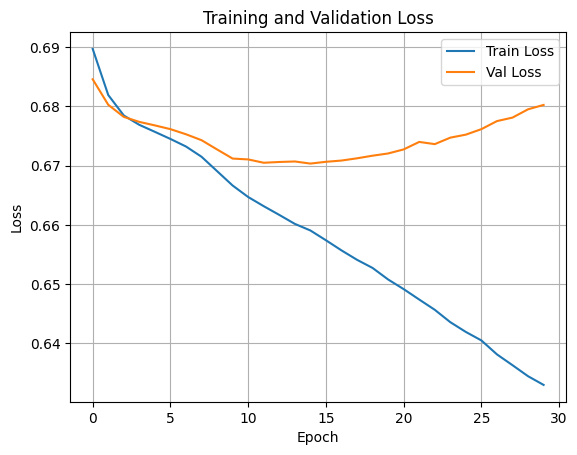

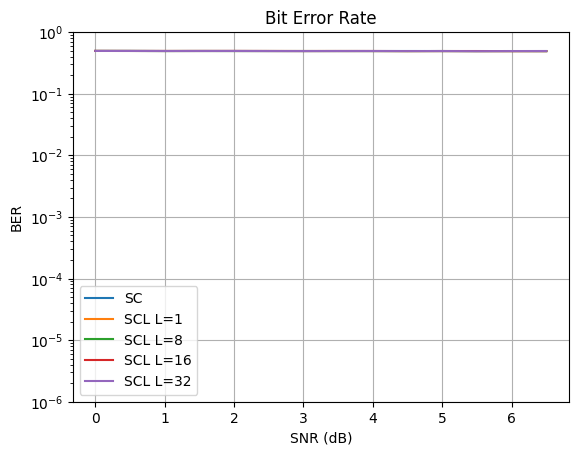

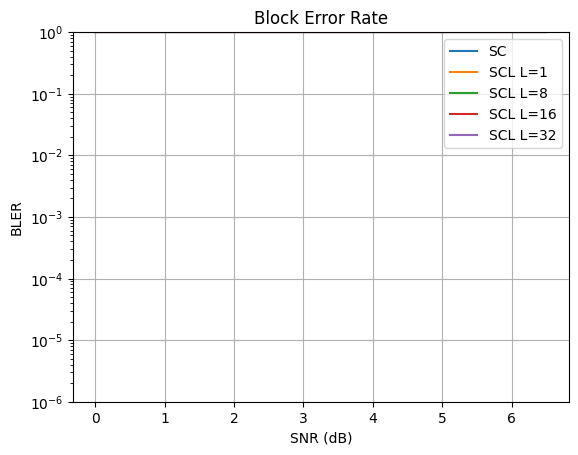

In [8]:
#latest modification
#RM-polar codes and machine learning simulations
#06/21/2025
import numpy as np
import matplotlib.pyplot as plt
import heapq
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ---- Configuration ----
BLOCK_LENGTH = 128
INFO_BITS = 64
RM_ORDER = 3
SNR_RANGE = np.arange(0, 7, 0.5)  # wider range for waterfall
LIST_SIZES = [1, 8, 16, 32]
NUM_FRAMES = 20000
BATCH_SIZE = 64
EPOCHS = 30
SNR_RANGE = np.arange(0, 7, 0.5)

# ---- BPSK Modulation and AWGN Channel ----
def bpsk_modulate(x):
    return 1 - 2 * x

def awgn_noise(x, snr_db, rate):
    snr_linear = 10 ** (snr_db / 10)
    sigma = np.sqrt(1 / (2 * rate * snr_linear))
    return x + sigma * np.random.randn(*x.shape)

def llr_awgn(y, snr_db, rate):
    snr_linear = 10 ** (snr_db / 10)
    sigma2 = 1 / (2 * rate * snr_linear)
    return 2 * y / sigma2

# ---- RM-Polar Construction (same as before) ----
def get_rm_polar_frozen_indices(N, K, rm_order):
    n = int(np.log2(N))
    indices = np.arange(N)
    bin_indices = np.array([list(np.binary_repr(i, n)) for i in indices], dtype=int)
    hamming_weights = bin_indices.sum(axis=1)
    rm_candidates = indices[hamming_weights >= rm_order]
    try:
        polar_reliability = np.load(f"polar_reliability_{N}.npy")
    except FileNotFoundError:
        print(f"polar_reliability_{N}.npy not found. Generating reliability sequence...")
        polar_reliability = np.argsort(np.random.rand(N))
        np.save(f"polar_reliability_{N}.npy", polar_reliability)
        print(f"Reliability sequence saved to polar_reliability_{N}.npy")
    polar_order = np.argsort(polar_reliability)
    filtered = [i for i in polar_order if i in rm_candidates]
    info_indices = np.array(filtered[:K])
    frozen_indices = np.setdiff1d(np.arange(N), info_indices)
    return frozen_indices

# ---- Polar Encoder ----
def polar_encode(u, frozen_indices):
    N = len(frozen_indices) + len(u)
    x = np.zeros(N, dtype=int)
    info_idx = np.setdiff1d(np.arange(N), frozen_indices)
    x[info_idx] = u
    n = int(np.log2(N))
    for i in range(n):
        step = 2 ** i
        for j in range(0, N, 2 * step):
            for k in range(step):
                x[j + k] ^= x[j + k + step]
    return x

# ---- SC Decoder ----
def sc_decode(llr, frozen_indices):
    N = len(llr)
    u_hat = np.zeros(N, dtype=int)
    info_idx = np.setdiff1d(np.arange(N), frozen_indices)
    u_hat[frozen_indices] = 0
    u_hat[info_idx] = (llr[info_idx] < 0).astype(int)
    return u_hat[info_idx]

# ---- SCL Decoder ----
def scl_decode(llr, frozen_indices, L):
    N = len(llr)
    paths = [(0.0, np.zeros(N, dtype=int))]
    info_idx = np.setdiff1d(np.arange(N), frozen_indices)
    for i in range(N):
        new_paths = []
        for pm, u in paths:
            if i in frozen_indices:
                u0 = u.copy()
                u0[i] = 0
                pm_new = pm + np.log1p(np.exp(-abs(llr[i])))
                new_paths.append((pm_new, u0))
            else:
                for bit in [0, 1]:
                    u_new = u.copy()
                    u_new[i] = bit
                    llr_i = llr[i]
                    pm_new = pm + (np.log1p(np.exp(-abs(llr_i))) if bit != (llr_i < 0) else 0)
                    new_paths.append((pm_new, u_new))
        paths = heapq.nsmallest(L, new_paths)
    best_path = min(paths, key=lambda x: x[0])[1]
    return best_path[info_idx]

# ---- RMPolarCode Class ----
class RMPolarCode:
    def __init__(self, N=128, K=64, rm_order=3):
        self.N = N
        self.K = K
        self.rm_order = rm_order
        self.rate = K / N
        self.frozen_indices = get_rm_polar_frozen_indices(N, K, rm_order)

    def polar_encode(self, u):
        return polar_encode(u, self.frozen_indices)

# ---- RNN Decoder ----
class RNNDecoder(nn.Module):
    def __init__(self, N, K, hidden_size=128):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, K)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

# ---- ML Decoder Utilities ----
def get_dataloaders(code, batch_size=64):
    X, Y = [], []
    for _ in range(10000):
        u = np.random.randint(0, 2, code.K)
        x = code.polar_encode(u)
        y = bpsk_modulate(x)
        y_noisy = awgn_noise(y, code.snr_db, code.rate)
        llrs = llr_awgn(y_noisy, code.snr_db, code.rate)
        X.append(llrs.reshape(-1, 1))
        Y.append(u)
    X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
    dataset = TensorDataset(X, Y)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def train_rnn_decoder(code, train_loader, val_loader, epochs=30, lr=0.001, device='cpu'):
    model = RNNDecoder(code.N, code.K).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer
    criterion = nn.BCELoss()
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            preds = model(batch_X)
            loss = criterion(preds, batch_Y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_X, val_Y in val_loader:
                val_X, val_Y = val_X.to(device), val_Y.to(device)
                val_preds = model(val_X)
                loss = criterion(val_preds, val_Y)
                val_loss += loss.item()
            val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}")
    return model, train_losses, val_losses

# ---- Evaluation ----
def evaluate_decoder(code, decoder_func, snrs, L=1):
    frozen_indices = code.frozen_indices
    rate = code.rate
    ber_curve, bler_curve = [], []
    for snr in snrs:
        bit_errors, block_errors, total_bits = 0, 0, 0
        for _ in range(NUM_FRAMES):
            u = np.random.randint(0, 2, code.K)
            x = code.polar_encode(u)
            y = bpsk_modulate(x)
            y_noisy = awgn_noise(y, snr, rate)
            llrs = llr_awgn(y_noisy, snr, rate)
            if decoder_func == "sc":
                u_hat = sc_decode(llrs, frozen_indices)
            elif decoder_func == "scl":
                u_hat = scl_decode(llrs, frozen_indices, L)
            else:
                raise ValueError("Decoder func must be 'sc' or 'scl'")
            bit_errors += np.sum(u != u_hat)
            block_errors += int(not np.array_equal(u, u_hat))
            total_bits += code.K
        ber_curve.append(bit_errors / total_bits)
        bler_curve.append(block_errors / NUM_FRAMES)
        print(f"SNR={snr:.1f} dB: BER={ber_curve[-1]:.2e}, BLER={bler_curve[-1]:.2e}")
    return ber_curve, bler_curve

# ---- Main ----
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    code = RMPolarCode(N=BLOCK_LENGTH, K=INFO_BITS, rm_order=RM_ORDER)
    code.snr_db = 2.0  # default for training data generation

    print(f"Code parameters: N={code.N}, K={code.K}, Rate={code.rate:.3f}, RM order={code.rm_order}")

    print("Running SC decoder...")
    ber_sc, bler_sc = evaluate_decoder(code, decoder_func="sc", snrs=SNR_RANGE)

    ber_scl_all, bler_scl_all = {}, {}
    for L in LIST_SIZES:
        print(f"Running SCL decoder with list size {L}...")
        ber_scl, bler_scl = evaluate_decoder(code, decoder_func="scl", snrs=SNR_RANGE, L=L)
        ber_scl_all[L] = ber_scl
        bler_scl_all[L] = bler_scl

    print("Training ML Decoder (RNN)...")
    train_loader, val_loader = get_dataloaders(code, batch_size=BATCH_SIZE)
    model, train_losses, val_losses = train_rnn_decoder(code, train_loader, val_loader, epochs=EPOCHS, device=device)

    # Plot training/validation losses
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot BER
    plt.figure()
    plt.semilogy(SNR_RANGE, ber_sc, label="SC")
    for L in LIST_SIZES:
        plt.semilogy(SNR_RANGE, ber_scl_all[L], label=f"SCL L={L}")
    plt.xlabel("SNR (dB)")
    plt.ylabel("BER")
    plt.ylim(1e-6, 1)
    plt.title("Bit Error Rate")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot BLER
    plt.figure()
    plt.semilogy(SNR_RANGE, bler_sc, label="SC")
    for L in LIST_SIZES:
        plt.semilogy(SNR_RANGE, bler_scl_all[L], label=f"SCL L={L}")
    plt.xlabel("SNR (dB)")
    plt.ylabel("BLER")
    plt.ylim(1e-6, 1)
    plt.title("Block Error Rate")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()